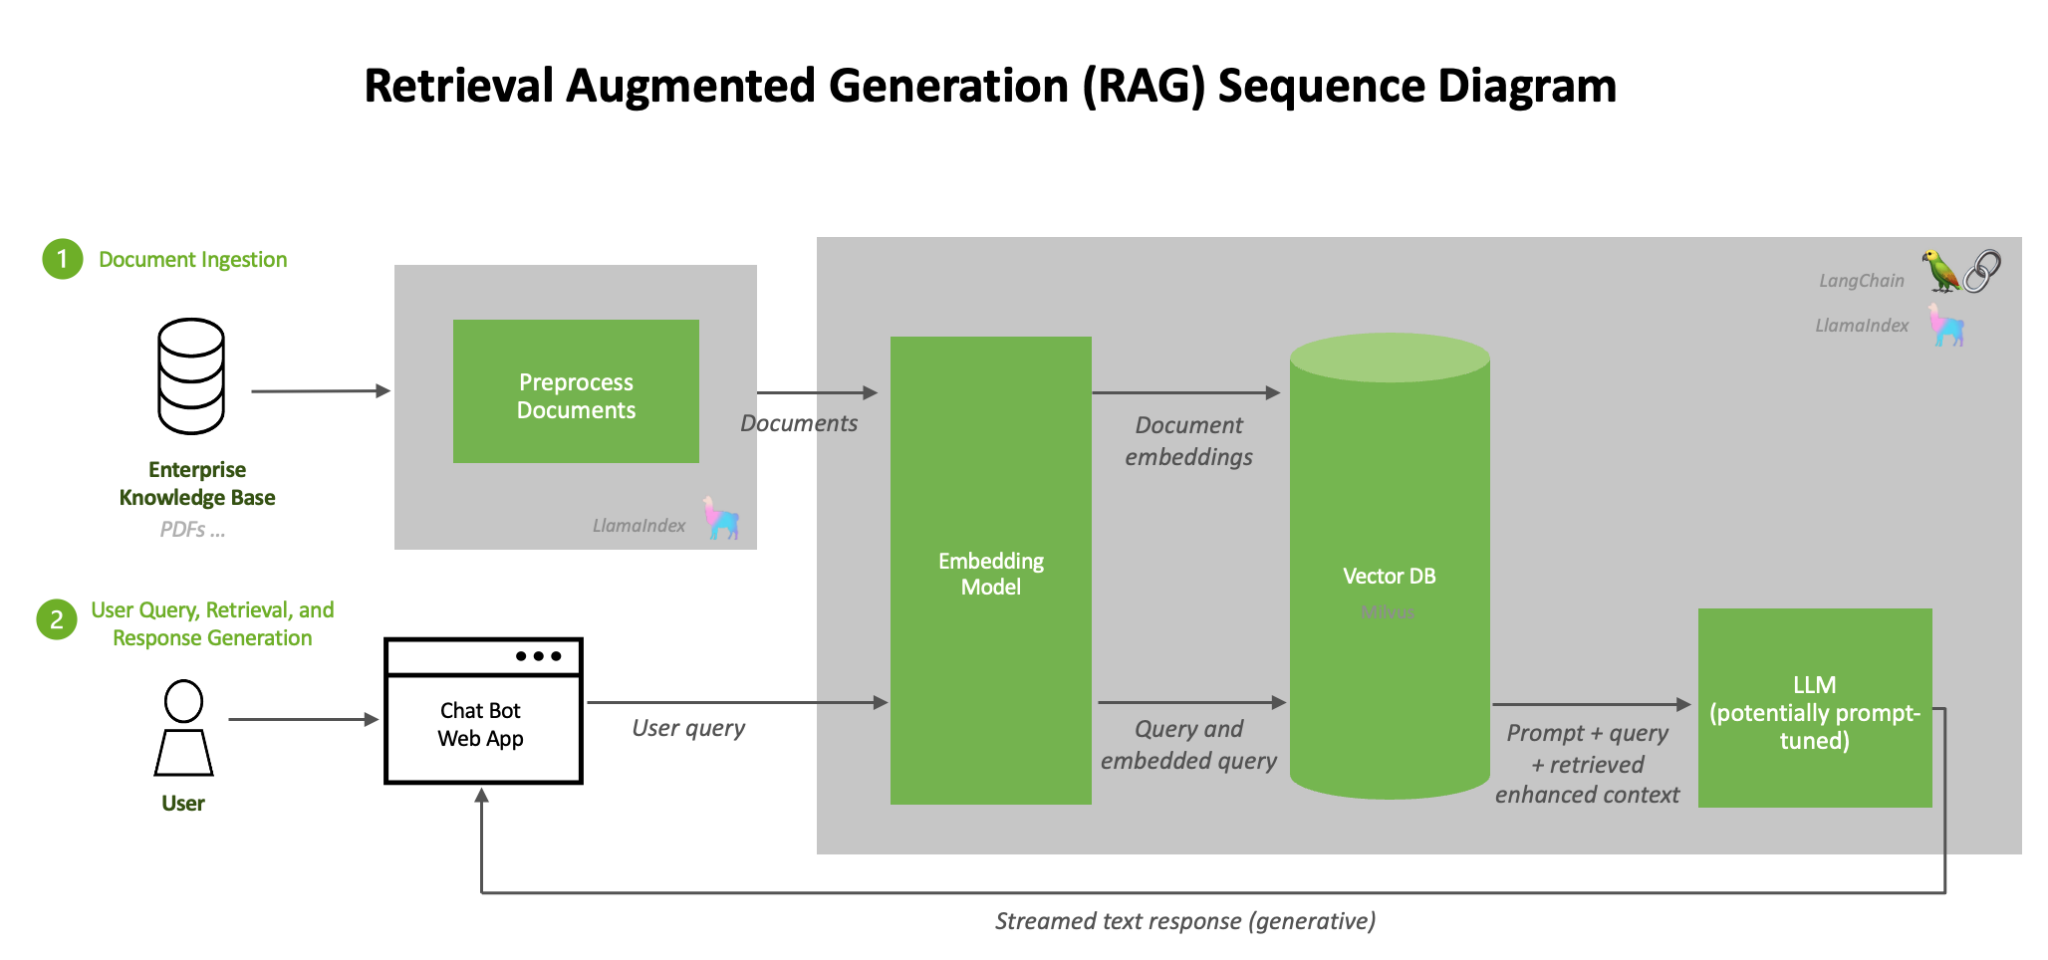

Image source - NVIDIA blog

> We need GPU with around 16gb RAM to run this Notebook. 
You can use GPU P100 available on kaggle or use Colab free GPU.

# Install Packages

In [1]:
!pip install PyMuPDF==1.23.21 llama_index==0.9.47 transformers accelerate bitsandbytes --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [2]:
!pip install llama-hub==0.0.78 --quiet

# Downloading data

It's a pdf having current affairs info.

In [3]:
!mkdir -p 'data/'
!wget --user-agent "Mozilla" "https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf" -O "data/Yojana.pdf"

--2024-02-17 09:00:33--  https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf
Resolving chahalacademy.com (chahalacademy.com)... 103.227.176.27
Connecting to chahalacademy.com (chahalacademy.com)|103.227.176.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32739743 (31M) [application/pdf]
Saving to: 'data/Yojana.pdf'

data/Yojana.pdf     100%[===================>]  31.22M  10.8MB/s    in 2.9s    

2024-02-17 09:00:36 (10.8 MB/s) - 'data/Yojana.pdf' saved [32739743/32739743]



# Install required packages

In [4]:
from pathlib import Path

from llama_hub.file.pymu_pdf.base import PyMuPDFReader
from llama_index import Document
import torch
from transformers import BitsAndBytesConfig
from llama_index.prompts import PromptTemplate
from llama_index.llms import HuggingFaceLLM
from llama_index import ServiceContext, VectorStoreIndex
from llama_index.node_parser import HierarchicalNodeParser
from llama_index.node_parser.text import SentenceSplitter
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index.storage.docstore import SimpleDocumentStore
from llama_index.storage import StorageContext
from llama_index.retrievers.auto_merging_retriever import AutoMergingRetriever
from llama_index.node_parser import get_leaf_nodes, get_root_nodes
from llama_index.query_engine import RetrieverQueryEngine

# Loading the data

In [5]:
loader = PyMuPDFReader()
docs0 = loader.load(file_path=Path("./data/Yojana.pdf"))

doc_text = "\n\n".join([d.get_content() for d in docs0])
docs = [Document(text=doc_text)]

# Downloading open source LLM(Zephyr) using HuggingFaceLLM and doing quantization

In [6]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<|system|>\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<|user|>\n{message.content}</s>\n"
        elif message.role == 'assistant':
            prompt += f"<|assistant|>\n{message.content}</s>\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<|system|>\n"):
        prompt = "<|system|>\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<|assistant|>\n"

    return prompt


llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    generate_kwargs={"do_sample": False},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# Downloading bge-base embedding model

In [7]:
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# SentenceSplitter

Parse text with a preference for complete sentences.In general, this class tries to keep sentences and paragraphs together.

In [8]:
# Default values are - chunk_size=1024, chunk_overlap=200
node_parser = SentenceSplitter.from_defaults(chunk_size=1024, chunk_overlap=200)
nodes = node_parser.get_nodes_from_documents(docs)

In [9]:
nodes[1]

TextNode(id_='225fb13f-2502-4b52-a8b2-a5e9f196da13', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='42ef9e57-34e3-43da-97c1-d167bb59279e', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='61650a4fb09709c8419edc8c9db573cfb876384e64d155b22b39ec132accced9'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='a6717bfc-b9e4-4bf2-8fcc-cb5056cfe078', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='b4ead0d2e92474db944b9a0a42d517da6e79763611c665fa2f5672fd3a1a4498'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='cb458412-8753-42e7-941d-c938d30aa91f', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='66bf3c251d6a3bd723b97058e58be5fb8045667e0aec2048c16ffcc123f951d0')}, text='MILLETS  \n1\nMILLETS\nYojana (January 2023)\nINTERNATIONAL YEAR OF MILLETS 2023\nIndia’s effort has resulted into United Nation’s declaration \nof year 2023 as International Ye

In [10]:
print(nodes[1].text)

MILLETS  
1
MILLETS
Yojana (January 2023)
INTERNATIONAL YEAR OF MILLETS 2023
India’s effort has resulted into United Nation’s declaration 
of year 2023 as International Year of Millets (IYM). India 
is on the way to become the global hub of millet production 
with more than 80% of Asia’s share of production of 
millets. India is the world’s largest producer of millets, 
accounting 20% of global production and having average 
yield of 1237 kg/hectare more than global average of 1229 
kg/hectare. Government of India has declared to celebrate 
the IYM as a Jan Andolan so that Indian millets, recipes 
and value-added products are accepted globally. The top 
five state producing millets are Rajasthan, Karnataka, 
Maharashtra, Uttar Pradesh and Haryana.
Millet production in India
According to World Food Programme, there are an 
estimated 1.2 billion people who consume millet as part 
of their diet.
Millet production has been stable over the past few 
years, with an estimated production of 28

# Issue in selecting chunk size - 
bge-base embedding model has **max token limit of 512** but we have created **chunks of size 1024.** While creating embedding for the contexts,the **input text after 512 tokens will get truncated when passing to embedding model.**

### Let's investigate!

In [11]:
text_tokens = embed_model._tokenizer.encode(nodes[1].text,truncation=True)
print(text_tokens)

[101, 4971, 8454, 1015, 4971, 8454, 10930, 18803, 1006, 2254, 16798, 2509, 1007, 2248, 2095, 1997, 4971, 8454, 16798, 2509, 2634, 1521, 1055, 3947, 2038, 4504, 2046, 2142, 3842, 1521, 1055, 8170, 1997, 2095, 16798, 2509, 2004, 2248, 2095, 1997, 4971, 8454, 1006, 1045, 24335, 1007, 1012, 2634, 2003, 2006, 1996, 2126, 2000, 2468, 1996, 3795, 9594, 1997, 4971, 3388, 2537, 2007, 2062, 2084, 3770, 1003, 1997, 4021, 1521, 1055, 3745, 1997, 2537, 1997, 4971, 8454, 1012, 2634, 2003, 1996, 2088, 1521, 1055, 2922, 3135, 1997, 4971, 8454, 1010, 9529, 2322, 1003, 1997, 3795, 2537, 1998, 2383, 2779, 10750, 1997, 13138, 2581, 4705, 1013, 20406, 2062, 2084, 3795, 2779, 1997, 13092, 2683, 4705, 1013, 20406, 1012, 2231, 1997, 2634, 2038, 4161, 2000, 8439, 1996, 1045, 24335, 2004, 1037, 5553, 1998, 6030, 2078, 2061, 2008, 2796, 4971, 8454, 1010, 19328, 1998, 3643, 1011, 2794, 3688, 2024, 3970, 16452, 1012, 1996, 2327, 2274, 2110, 5155, 4971, 8454, 2024, 16815, 1010, 12092, 1010, 12434, 1010, 14940, 7970

In [12]:
text_tokens.__len__()

512

In [13]:
embed_model._tokenizer.decode(text_tokens)

2024-02-17 09:02:43.216947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 09:02:43.217051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 09:02:43.343179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'[CLS] millets 1 millets yojana ( january 2023 ) international year of millets 2023 india ’ s effort has resulted into united nation ’ s declaration of year 2023 as international year of millets ( iym ). india is on the way to become the global hub of millet production with more than 80 % of asia ’ s share of production of millets. india is the world ’ s largest producer of millets, accounting 20 % of global production and having average yield of 1237 kg / hectare more than global average of 1229 kg / hectare. government of india has declared to celebrate the iym as a jan andolan so that indian millets, recipes and value - added products are accepted globally. the top five state producing millets are rajasthan, karnataka, maharashtra, uttar pradesh and haryana. millet production in india according to world food programme, there are an estimated 1. 2 billion people who consume millet as part of their diet. millet production has been stable over the past few years, with an estimated prod

Hence, the embedding vector which gets created for all the contexts will be of low quality as it has taken the context of first 512 words while creating embedding. Let's see it's impact on the RAG performance.

> **Always, the Chunk Size should be less than or equal to Embedding model max token limit.**

# Service Context

The service context container is a utility container for LlamaIndex index and query classes. The container contains the following objects that are commonly used for configuring every index and query, such as the LLM, the PromptHelper (for configuring input size/chunk size), the BaseEmbedding (for configuring the embedding model), and more.

In [14]:
service_context = ServiceContext.from_defaults(llm=llm, embed_model=embed_model)

# VectorStoreIndex

A vector store takes care of storing embedded data and performing vector search for you. 

In [15]:
vector_index = VectorStoreIndex(nodes, service_context=service_context)
vector_query_engine = vector_index.as_query_engine(similarity_top_k=3)

# Let's test the RAG system on questions from the pdf.

In [16]:
questions = [
    "Which Country is the largest producer of millets?",
    "What is Samagra Shiksha Scheme?",
    "Which new initiative is proposed in budget to eliminate anaemia by 2047.",
    "What is the median age of India, China and Germany?",
    "How much budget is allocated to Natural farming?",
]

# Only 2 answers are correct out of 5

In [17]:
for q in questions:
    response = vector_query_engine.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production and having an average yield of 1237 kg/hectare more than global average of 1229 kg/hectare. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  The given context information does not mention the Samagra Shiksha Scheme. It only provides information about various schemes and initiatives related to rural development, youth and sports, Union Budget, Start-Up India, TechAde, Cooperative to Prosperity, Renewable Resources, Panchayati Raj, Rural crafts, Water conservation, and Sustainable agriculture development. 

Therefore, the answer to the query is that the given context information does not provide information about the Samagra Shiksha Scheme. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A new initiative is proposed in budget to eliminate anaemia by 2047. The specific name of the initiative is not mentioned in the given context information. However, it is mentioned that a special scheme namely Sickle Cell Anaemia Elimination Mission would be launched. It is possible that this scheme may also contribute to the elimination of anaemia, but it is not explicitly stated. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  According to the given context information, the median age of India is not explicitly mentioned. However, it is mentioned that India is still young and going to remain the youngest until 2047, with a billion Indians under the age of 35 years. The median age of China and Germany is not mentioned in the given context information. 


Question - How much budget is allocated to Natural farming? 

Response -  Rs. 459 crores have been allocated in this budget for promoting natural farming. 




# Let's update chunk size to 512 and keep everything else same

In [18]:
node_parser = SentenceSplitter.from_defaults(chunk_size = 512, chunk_overlap=200)
nodes = node_parser.get_nodes_from_documents(docs)
vector_index_512 = VectorStoreIndex(nodes,service_context=service_context,verbose=True)
vector_query_engine_512 = vector_index_512.as_query_engine(similarity_top_k=3,verbose=True)

# Test RAG performance with 512 chunk size

> **4 answers out of 5 are correct**

So, with just changing the chunk size as per embedding model max token limit -> **performance improved drastically :)**

In [19]:
for q in questions:
    response = vector_query_engine_512.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  The given context information does not mention the Samagra Shiksha Scheme. Therefore, it cannot be answered based on the given information. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A new initiative named Sickle Cell Anaemia Elimination Mission is proposed in the budget to eliminate anaemia by 2047. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  The median age in India is 28.4, while it is 38 in China and 47 in Germany. 


Question - How much budget is allocated to Natural farming? 

Response -  Rs. 459 crores have been allocated in this budget for promoting natural farming, which is being transformed as a mass movement in the country by the Prime Minister. 




# Let's debug further question 2 - 
> "What is Samagra Shiksha Scheme?"

Let's get the context chunks for this query and we can see below, the relevant context where we have info for "Samagra" is not part of the 3 contexts we got.

In [20]:
vector_query_retriever = vector_index_512.as_retriever(similarity_top_k=3,verbose=True)
contexts = vector_query_retriever.retrieve(questions[1])

for c in contexts:
    if "Samagra" in c.text:
        print("\nYES\n")
    else:
        print("\nNO\n")

print([c.text+"*"*100 for c in contexts])


NO


NO


NO

['• A total of 2.83 crore houses have been sanctioned and \n2.14 crore have been completed by February 10, 2023, \nunder the Scheme.\nPradhan Mantri Gram Sadak Yojana\n• The primary objective of the scheme is to promote \neconomic activities in rural India by providing \nall-weather road connectivity to the eligible un-\nconnected rural habitations.\n• Since, the inception of the scheme, a total of 1,74,029 \nworks with a road length of 7,25,774 kilometres were \nconstructed till 10 February 2023.\nNational Rural Livelihoods Mission\n• It aims at creating diversified and gainful self-\nemployment to the rural poor through sustainable \nlivelihood enhancements and improved access to \nfinancial services. Presently, the scheme covers 737 \ndistricts spread over 2,68,675 Gram Panchayats and \n7,40,845 village of the country. \nNational Social Assistance Programme\n• The majors chemes under this programme include \nIndira Gandhi National Old Age Pension Scheme, \nIndira Gand

# But why we did not get the relevant context for question 2?

Reason could be -
> In question 2, there are 3 main tokens which are "Samagra", "Siksha" and "Scheme". Out of these 3, "Scheme" is popular english word and will be present in the model vocublary but other words are not popular english words kind of Hindi words writted in English. So, the embedding model tokens won't have these words as complete token but it will be part of tokeniser as ngrams.

Let's test our hypothesis.

In [21]:
embed_model._tokenizer.tokenize("Samagra Shiksha Scheme")

['sam', '##ag', '##ra', 'shi', '##ksha', 'scheme']

# Our hypothesis is right!!

"Scheme" is only present as complete word in tokens and rest are kind of ngrams. Now, when we create embedding for these tokens and compare with other bigger contexts of size 512 tokens, there are high chance it will have higher match with contexts having words "Scheme" more.

If you check the retrieved contexts for this query, you will see that the count of "Scheme" word is high.

# What is the solution for this?
> Either increase the number of contexts retrieved(similarity_top_k) value to higher value than 3.

> Or we can decrease the chunk size to 256 or 128 so that the chunk embedding gives more importance to these rare words as number of total words will be less.

> Do Hybrid search, sparse search and dense search together. **Out of scope for this tutorial, will cover in later tutorials.**

Ideally, we should have a system where we can **compare the query with smaller context chunks but in return we pass bigger context chunks to LLM** so that it has extra info to answer the question.

> The Solution is **HierarchicalNodeParser + AutoMergingRetriever**!!

# HierarchicalNodeParser

Splits a document into a recursive hierarchy Nodes using a NodeParser. Chunk size is passed as list like [2048,512,256]

NOTE: this will return a hierarchy of nodes in a flat list, where there will be overlap between parent nodes (e.g. with a bigger chunk size), and child nodes per parent (e.g. with a smaller chunk size).

For instance, this may return a list of nodes like: 
- list of top-level nodes with chunk size 2048
- list of second-level nodes, where each node is a child of a top-level node,chunk size 512
- list of third-level nodes, where each node is a child of a second-level node, chunk size 256

In [22]:
hier_node_parser = HierarchicalNodeParser.from_defaults([2048,512,256], 
                                                        chunk_overlap=20)
hier_nodes = hier_node_parser.get_nodes_from_documents(docs)

# Let's investigate how HierarchicalNodeParser works

Print root node(at index 1) text and length. Root node chunk size is less than 2048 and greater than 512.

In [23]:
print("length -", len(hier_nodes[1].text.split()),"\n\n"),print("Text - ",hier_nodes[1].text)

length - 714 


Text -  2 
MILLETS
places the use of millets is systematically discouraged from 
cultivation; for example, Kodo Kotki Hatao Soyabean Lagao 
(Remove Kodo and Little millets and grow soyabean) was 
a famous slogan from 2000s undivided Madhya Pradesh.
Nutrition from millets
Apart from being inexpensive and easier to grow, they 
are a rich source of many vitamins, minerals, and fibre. 
o  Niacin, a type of Vitamin B found in millets is useful in 
energy production, and nerve health and keeps the digestive 
tract healthy.  
o  The magnesium. Zinc, and fibre found in millets make it 
an excellent food for blood sugar regulation, especially for 
PCOD and Diabetes. Folic acid helps with iron assimilation 
and improves skin, health, and fertility.
o  The absence of gluten makes it simple to digest. The cereal 
primarily contains unsaturated fat, which has a low-fat 
content. Given its lower glycemic response or reduced 
capacity to spike blood levels, it helps diabetics maintain

(None, None)

It has 3 child nodes

In [24]:
hier_nodes[1].child_nodes

[RelatedNodeInfo(node_id='16db5e29-9276-4e2a-8880-98c8700e383e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='dd55337667af2b0e3e103c12f2e0222bd0e80f75b9652e029b74486cbe71c2d0'),
 RelatedNodeInfo(node_id='1c7154e2-f377-41ab-a5e6-6ba17390fb9a', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='16e6e8ffee7de01e890983aa6e582d8b5effeef6ee9d0a6afa8c368607a36e64'),
 RelatedNodeInfo(node_id='a318abb9-52e1-4934-9d4e-9176fcc8fce9', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='a2902c43144f8290bd9a3b4e785e08e765e4ddbfdd98c7a2cd6505f6f16c58f0')]

Let's print text and length of each child node of root node at index 1.

Child node chunk size will be less than 512 as it's first level child.

In [25]:
for i,node in enumerate(hier_nodes):
    if node.id_ in [c.node_id for c in hier_nodes[1].child_nodes]:
        print("index-",i,"\n","length -", len(node.text.split()),"\n",
              "Text - ",node.text)
        print("-"*50)

index- 22 
 length - 327 
 Text -  2 
MILLETS
places the use of millets is systematically discouraged from 
cultivation; for example, Kodo Kotki Hatao Soyabean Lagao 
(Remove Kodo and Little millets and grow soyabean) was 
a famous slogan from 2000s undivided Madhya Pradesh.
Nutrition from millets
Apart from being inexpensive and easier to grow, they 
are a rich source of many vitamins, minerals, and fibre. 
o  Niacin, a type of Vitamin B found in millets is useful in 
energy production, and nerve health and keeps the digestive 
tract healthy.  
o  The magnesium. Zinc, and fibre found in millets make it 
an excellent food for blood sugar regulation, especially for 
PCOD and Diabetes. Folic acid helps with iron assimilation 
and improves skin, health, and fertility.
o  The absence of gluten makes it simple to digest. The cereal 
primarily contains unsaturated fat, which has a low-fat 
content. Given its lower glycemic response or reduced 
capacity to spike blood levels, it helps diabeti

Let's print child nodes of first child node whose index position is 22.

These child nodes will have chunk size less than 256 as they are second level child.

In [26]:
for i,node in enumerate(hier_nodes):
    if node.id_ in [c.node_id for c in hier_nodes[22].child_nodes]:
        print("index-",i,"\n","length -", len(node.text.split()),"\n",
              "Text - ",node.text)
        print("-"*50)

index- 101 
 length - 157 
 Text -  2 
MILLETS
places the use of millets is systematically discouraged from 
cultivation; for example, Kodo Kotki Hatao Soyabean Lagao 
(Remove Kodo and Little millets and grow soyabean) was 
a famous slogan from 2000s undivided Madhya Pradesh.
Nutrition from millets
Apart from being inexpensive and easier to grow, they 
are a rich source of many vitamins, minerals, and fibre. 
o  Niacin, a type of Vitamin B found in millets is useful in 
energy production, and nerve health and keeps the digestive 
tract healthy.  
o  The magnesium. Zinc, and fibre found in millets make it 
an excellent food for blood sugar regulation, especially for 
PCOD and Diabetes. Folic acid helps with iron assimilation 
and improves skin, health, and fertility.
o  The absence of gluten makes it simple to digest. The cereal 
primarily contains unsaturated fat, which has a low-fat 
content. Given its lower glycemic response or reduced 
capacity to spike blood levels, it helps diabet

# Let's get all the leaf nodes

In [27]:
leaf_nodes = get_leaf_nodes(hier_nodes)

In [28]:
len(hier_nodes),len(leaf_nodes)

(258, 166)

# SimpleDocumentStore
Create a SimpleDocumentStore to store all the Hierarchical nodes 

# StorageContext
Save the docstore in StorageContext

In [29]:
docstore = SimpleDocumentStore()

# insert nodes into docstore
docstore.add_documents(hier_nodes)

# define storage context (will include vector store by default too)
storage_context = StorageContext.from_defaults(docstore=docstore)

# Create VectorStoreIndex using leaf nodes only.

In [30]:
base_index = VectorStoreIndex(
    leaf_nodes,
    storage_context=storage_context,
    service_context=service_context,
)

# AutoMergingRetriever

It looks at a set of leaf nodes and recursively “merges” subsets of leaf nodes that reference a parent node beyond a given threshold. This allows us to consolidate potentially disparate, smaller contexts into a larger context that might help synthesis.

In [31]:
base_retriever = base_index.as_retriever(similarity_top_k=3)
retriever = AutoMergingRetriever(base_retriever, storage_context, verbose=True)

# RetrieverQueryEngine

Using this we can query our retriever

In [32]:
query_engine = RetrieverQueryEngine.from_args(retriever, service_context=service_context)

# ALL 5 answers are correct!!

In [33]:
for q in questions:
    response = query_engine.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  The Samagra Shiksha Scheme is a Centrally Sponsored Scheme that has been aligned with the policy to promote fitness and physical activities. Under this scheme, sports grants are provided annually to all government schools. The scheme aims to promote fitness as easy, fun, and free, spread awareness on fitness and various physical activities that promote fitness through focused campaigns, encourage indigenous sports, and make fitness reach every school, college/university, panchayat/village, etc. 


> Merging 1 nodes into parent node.
> Parent node id: 90bb9b04-daf9-4214-a634-1402284fb74c.
> Parent node text: Health
• Expenditure on health as percentage of GDP increased 
from 1.4 per cent in 2019-20 to 2....



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A special scheme namely Sickle Cell Anaemia Elimination Mission would be launched. 




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  The median age in India is 28.4, while it is 38 in China and 47 in Germany. 


Question - How much budget is allocated to Natural farming? 

Response -  Rs. 459 crores have been allocated in this budget for promoting natural farming, as mentioned in the given context information. 




In [34]:
contexts = retriever.retrieve(questions[1])
for c in contexts:
    if "Samagra" in c.text:
        print("\nYES\n")
    else:
        print("\nNO\n")

print([c.text+"*"*100 for c in contexts])


YES


NO


NO

['Regular \nexercise and participation in sports provide a variety \nof positive social and health effects. It affects physical \nfitness directly, but it also instils good lifestyle choices in \nkids and young adults, encouraging them to stay active \nand fight non-communicable diseases.\nThe goals and objectives of this are:  \n¾ \nTo promote fitness as easy, fun and free. \n¾ \nTo spread awareness on fitness and various \nphysical activities that promote fitness through \nfocused campaigns. \n¾ \nTo encourage indigenous sports. \n¾ \nTo make fitness reach every school, college/\nuniversity, panchayat/village, etc.  \n¾ \nTo create a platform for citizens of India to share \ninformation, drive awareness and encourage \nsharing of personal fitness stories.\nInitiatives\n1.  Samagra Shiksha Scheme: The Centrally Sponsored \nScheme of Samagra Shiksha has been aligned with the \npolicy. Under the scheme, sports grant on an annual \nbasis has been provided to all governmen